# Importación de librerias

In [ ]:
import pandas as pd 
pd.set_option("display.max_rows", 100)
import matplotlib.pyplot as plt 
import os
import glob

# Funciones usadas para leer los múltiples archivos .csv y generar un solo archivo data.csv

In [ ]:
#Combine csv files in a directory to a target direcotry

def combine_csv_incrementally(folder_path, target_directory, chunk_size=10000):
    # Open a file to write the combined data incrementally
    first_chunk = True

    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    print('ready for read: ')
    print(csv_files)

    for file in csv_files:
        file_path = os.path.join(folder_path, file)

        # Read the CSV in chunks
        for chunk in pd.read_csv(file_path, chunksize=chunk_size, delimiter=",",low_memory=False,on_bad_lines='skip'):
            # If it's the first chunk, write headers; otherwise, don't
            chunk.to_csv(target_directory+os.sep+os.path.basename(os.path.normpath(folder_path))+'.csv', mode='a', header=first_chunk, index=False)
            first_chunk = False

#Combine csv files on subirectories from a source directory to a target directory
def combine_data_by_directories(source_dir,target_dir):

    for dirpath, dirnames, filenames in os.walk(source_dir):
        if  filenames:
            print(f"reading from directory: {dirpath}")
            #combine_csv_incrementally(dirpath,target_dir)

        #df = read_and_combine_csv_in_chunks(dirpath)

def read_and_combine_with_dask(folder_path):
    # Read all CSV files using dask (it handles larger-than-memory data)
    csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

    ddf = dd.read_csv(csv_files)

    # Perform operations on the dataframe
    ddf = ddf.compute()  # Convert to pandas dataframe for final operation
    return ddf


#Read csv files into dataframe
def read_csv_files(source_path,chunk_size=10000):

    #Set the pattern csv files
    pattern_file = os.path.join(source_path, '*.csv')

    # List of csv files in source path
    files = glob.glob(pattern_file)

    # Dataframes list
    dataframes = []

    # Read csv files
    for file in files:
        print('append file: '+file)
        df = pd.read_csv(file,chunk_size=chunk_size, delimiter=",",low_memory=False)
        dataframes.append(df)
    return df

def parse_files_to_parquet(source_dir,parquet_file):

    # Initialize an empty list to hold DataFrames
    df_list = []

    # Loop through each CSV file in the directory
    for filename in os.listdir(source_dir):
        if filename.endswith('.csv'):  # Ensure we're reading only CSV files
            csv_path = os.path.join(source_dir, filename)
            print(f"Reading {csv_path}")

            # Read the CSV into a DataFrame
            #df = pd.read_csv(csv_path)
            chunk_iter,read_flag = read_csv_file(csv_path)
            if read_flag == '1':
                # Append the DataFrame to the list
                # Iterate over each chunk and append it to the list
                for chunk in chunk_iter:
                     # Clean/convert the 'Bici' column (or any other columns with issues)
                    chunk['Bici'] = pd.to_numeric(chunk['Bici'], errors='coerce')  # Convert to numeric, set invalid values to NaN
                    if 'Ciclo_Estacion_Arribo' in chunk.columns:
                        chunk['Ciclo_Estacion_Arribo'] = pd.to_numeric(chunk['Ciclo_Estacion_Arribo'], errors='coerce')  # Convert to numeric, set invalid values to NaN
                    if 'Ciclo_Estacion_Retiro' in chunk.columns:
                        chunk['Ciclo_Estacion_Retiro'] = pd.to_numeric(chunk['Ciclo_Estacion_Retiro'], errors='coerce')
                    if 'Ciclo_EstacionArribo' in chunk.columns:
                        chunk['Ciclo_EstacionArribo'] = pd.to_numeric(chunk['Ciclo_EstacionArribo'], errors='coerce')

                    df_list.append(chunk)


    # Concatenate all DataFrames into a single DataFrame
    merged_df = pd.concat(df_list, ignore_index=True)

    # Write the merged DataFrame to a Parquet file
    merged_df.to_parquet(parquet_file, engine='pyarrow', compression='snappy')

    print(f"CSV files have been merged and saved as Parquet at {parquet_file}")

#Combine csv files on subirectories from a source directory to a target directory
def parse_files_by_directories(source_dir,target_dir):

    for dirpath, dirnames, filenames in os.walk(source_dir):
        if  filenames:
            print(f"reading from directory: {dirpath}")
            parquet_file = target_dir+os.sep+os.path.basename(os.path.normpath(dirpath))+'.parquet'
            print(f"parquet file: {parquet_file}")
            parse_files_to_parquet(dirpath,parquet_file)

        #df = read_and_combine_csv_in_chunks(dirpath)

: 

# Función de lectura de datos

In [ ]:
# Con esta función leemos un archivo CSV por chunks. Se define un tamaño de chunk de 100_000 filas
def read_csv_file(file,chunk_size=100_000):
    read_flag='1'
    df = pd.DataFrame()
    try:
        df = pd.read_csv(file, chunksize=chunk_size,delimiter=",",low_memory=False,on_bad_lines='skip')
        print("CSV file loaded successfully.")
    except FileNotFoundError:
        print(f"Error: The file at {file} does not exist.")
        read_flag='0'
    except pd.errors.ParserError as e:
        print(f"Error: There was an issue parsing the file at {file}.")
        print(f"{e}")
        read_flag='0'
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        read_flag='0'
    return df,read_flag

# EDA

### Lectura de los archivos .csv

In [ ]:
# Colocar aquí el path en el cual se encuentra el archivo data.csv   
# Ejemplo: file  = '/home/irving/Descargas/data.csv'
file  = '/home/irving/Descargas/data.csv'
df,read_flag = read_csv_file(file)

CSV file loaded successfully.


### Extracción de un dataframe con la información del género y la edad del usuario

In [4]:
# Creamos un datarame vacío. Colocalos las columnas que se van a utilizar y, por cada chunk, agrupamos 
# los datos por las columnas seleccionadas. Pegamos los resultados en el dataframe users_df
users_df =  pd.DataFrame()
users_columns = ['Genero_Usuario','Edad_Usuario']

for chunk in df:
    details = chunk[users_columns]
    details['count'] = 1
    summary = details.groupby(users_columns).sum().reset_index()
    users_df = pd.concat([users_df,summary], ignore_index=True)

/tmp/ipykernel_23033/1957768937.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  details['count'] = 1
/tmp/ipykernel_23033/1957768937.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  details['count'] = 1
/tmp/ipykernel_23033/1957768937.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [5]:
# Agrupamos los datos por las columnas seleccionadas y sumamos los conteos
users_output=users_df.groupby(users_columns).sum().reset_index()

In [6]:
# Definimos los bins y las etiquetas para la columna 'Edad_Usuario'
bins = [1, 28, 33, 41, 200]
labels = ['<28', '28-32', '33-41', '42>']

# Convertimos la columna 'Edad_Usuario' a enteros
users_output['Edad_Usuario'] = users_output['Edad_Usuario'].astype(int)

# Creamos la nueva columna 'Edad_Rangos' utilizando pd.cut y los bins preestablecidos
users_output['Edad_Rangos'] = pd.cut(users_output['Edad_Usuario'], bins, labels=labels)

### Gráfica de pastel de los usuarios por edad

/tmp/ipykernel_23033/1412303617.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_range_counts = users_output.groupby('Edad_Rangos')['count'].sum()


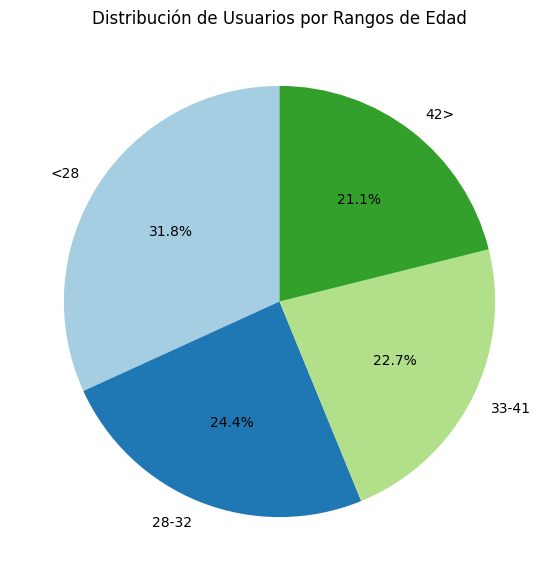

In [7]:
# Agrupamos los datos por 'Edad_Rangos' y sumamos los conteos
age_range_counts = users_output.groupby('Edad_Rangos')['count'].sum()

# Creamos la gráfica de pastel
plt.figure(figsize=(7, 7))
age_range_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribución de Usuarios por Rangos de Edad')
plt.ylabel('') 
plt.show()

### Gráfica de pastel para los usuarios por género

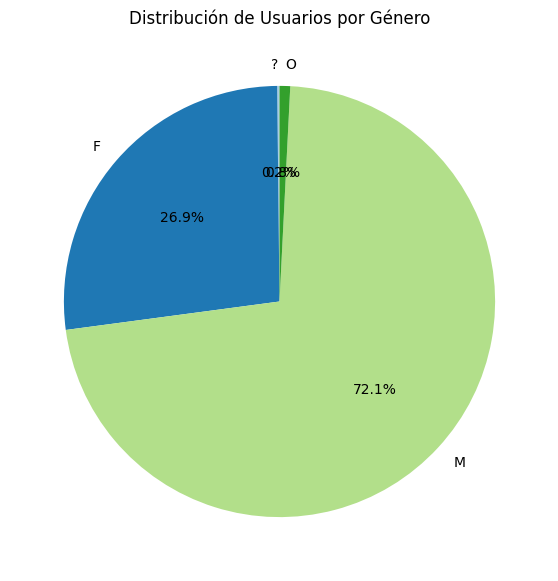

In [8]:
# Agrupamos los datos por 'Genero_Usuario' y sumamos los conteos
gender_counts = users_output.groupby('Genero_Usuario')['count'].sum()

# Creamos la gráfica de pastel
plt.figure(figsize=(7, 7))
gender_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribución de Usuarios por Género')
plt.ylabel('')  
plt.show()

### Gráfica de barras de usuarios por edad

/tmp/ipykernel_23033/795585423.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  users_output.groupby('Edad_Rangos')['count'].sum().plot(kind='bar', color='skyblue')


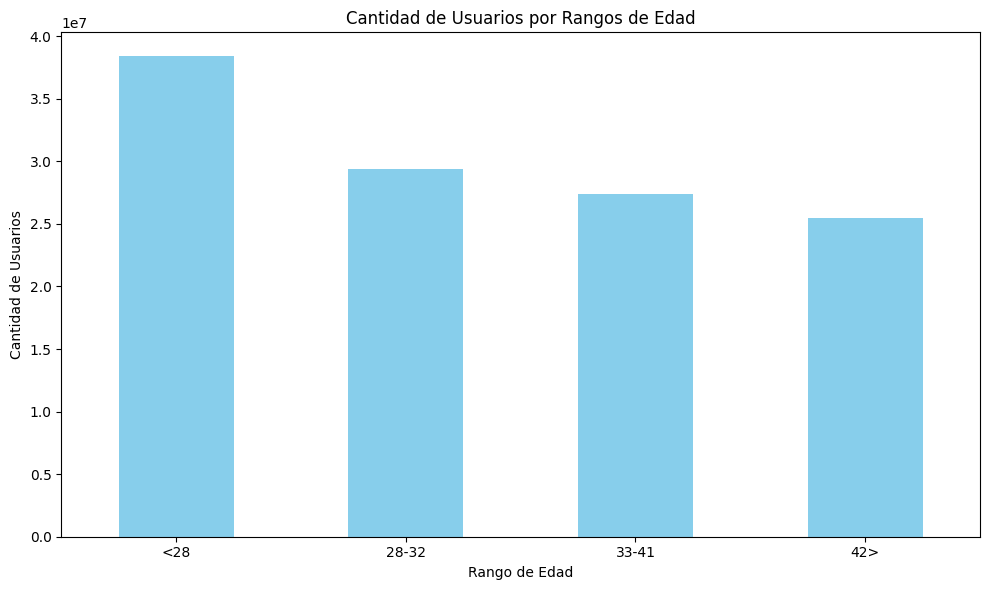

In [9]:
# Graficamos la cantidad de usuarios por rangos de edad
plt.figure(figsize=(10, 6))
users_output.groupby('Edad_Rangos')['count'].sum().plot(kind='bar', color='skyblue')
plt.title('Cantidad de Usuarios por Rangos de Edad')
plt.xlabel('Rango de Edad')
plt.ylabel('Cantidad de Usuarios')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

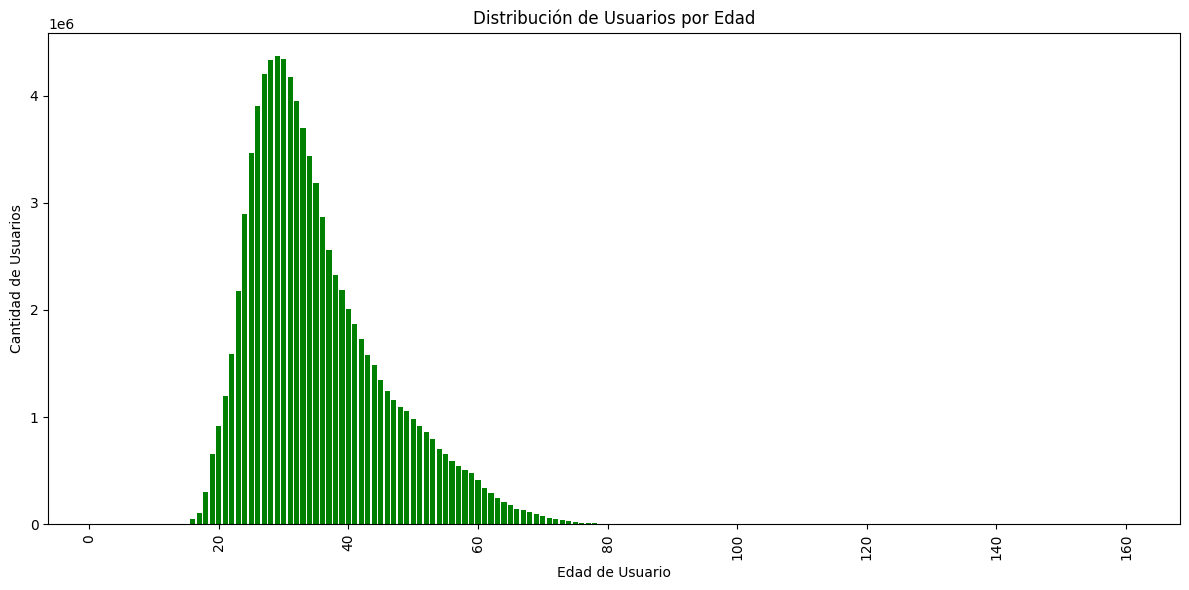

In [10]:
# Extraemos el histograma de edades de los usuarios
plt.figure(figsize=(12, 6))
plt.bar(users_output['Edad_Usuario'], users_output['count'], color='green')
plt.title('Distribución de Usuarios por Edad')
plt.xlabel('Edad de Usuario')
plt.ylabel('Cantidad de Usuarios')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Gráficas de barras de usuarios por género

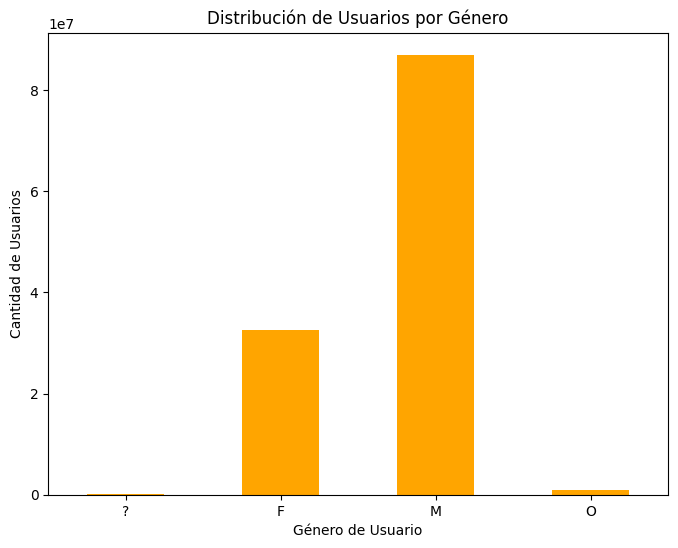

In [11]:
# Agrupamos los datos por 'Genero_Usuario' y sumamos los conteos
gender_counts = users_output.groupby('Genero_Usuario')['count'].sum()

# Creamos la gráfica de barras. Observamos que hay dos etiquetas distintas a 'F' y a 'M'
plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar', color='Orange')
plt.title('Distribución de Usuarios por Género')
plt.xlabel('Género de Usuario')
plt.ylabel('Cantidad de Usuarios')
plt.xticks(rotation=0)
plt.show()

### Creación de la columna de duración de viajes en minutos

#### IMPORTANTE: Para leer esta segunda parte, hay que volver a correr la celda donde se crea el dataframe por chunks

In [12]:
# Volvemos a leer el archivo CSV
df,read_flag = read_csv_file(file)

CSV file loaded successfully.


In [13]:
# Creamos un nuevo DataFrame con solo las columnas 'Hora_Arribo' y 'Hora_Retiro' de cada chunk en df
hora_df = pd.DataFrame()
hora_columns = ['Hora_Arribo', 'Hora_Retiro']
for chunk in df:
    temp = chunk[hora_columns].sample(n=10_000, random_state=42, replace = True).copy()  # Muestreamos 10,000 observaciones de cada chunk
    hora_df = pd.concat([hora_df, temp], ignore_index=True)

In [14]:
# Convertimos las columnas 'Hora_Arribo' y 'Hora_Retiro' a tipo datetime
hora_df['Hora_Arribo'] = pd.to_datetime(hora_df['Hora_Arribo'], format='%H:%M:%S', errors='coerce')
hora_df['Hora_Retiro'] = pd.to_datetime(hora_df['Hora_Retiro'], format='%H:%M:%S', errors='coerce')

In [15]:
# Calculamos la diferencia en minutos entre 'Hora_Arribo' y 'Hora_Retiro'. 
# Truncamos los valores negativos y mayores a 1440 minutos (24 horas) para quedarnos con un rango entre 0 y 1440 minutos
hora_df['Diferencia_minutos'] = (hora_df['Hora_Arribo'] - hora_df['Hora_Retiro']).dt.total_seconds() / 60
hora_df['Diferencia_minutos'] = hora_df['Diferencia_minutos'].apply(lambda x: x + 1440 if x < 0 else (x - 1440 if x > 1440 else x))


### Creación del histograma de la columna de duración de viaje por minutos

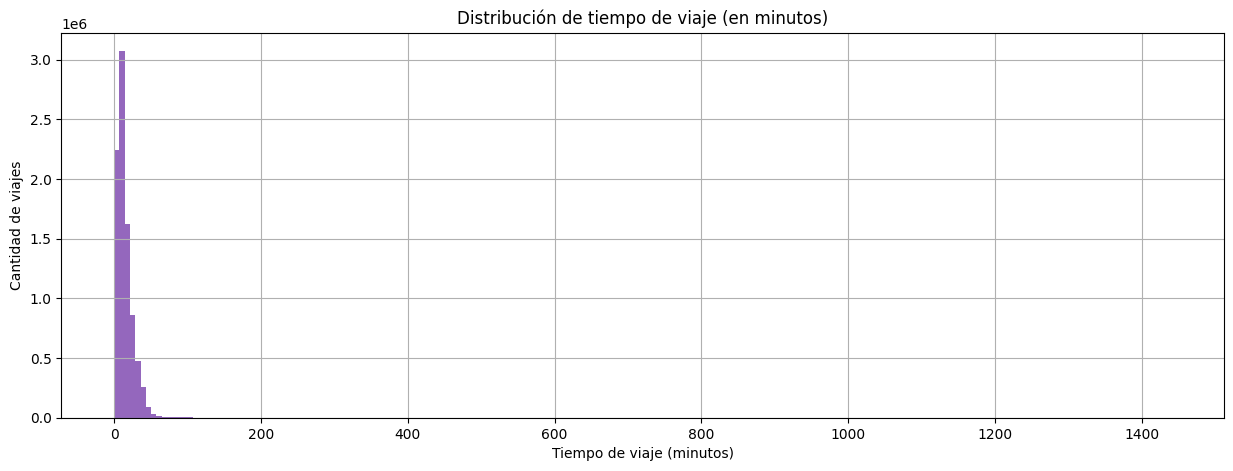

In [16]:
# Creamos el histograma 
hora_df.Diferencia_minutos.hist(bins=200,figsize=(15,5), color = 'C4')

# Editamos las gráficas
plt.title('Distribución de tiempo de viaje (en minutos)')
plt.xlabel('Tiempo de viaje (minutos)')
plt.ylabel('Cantidad de viajes')
plt.xticks(rotation=0)
plt.show()

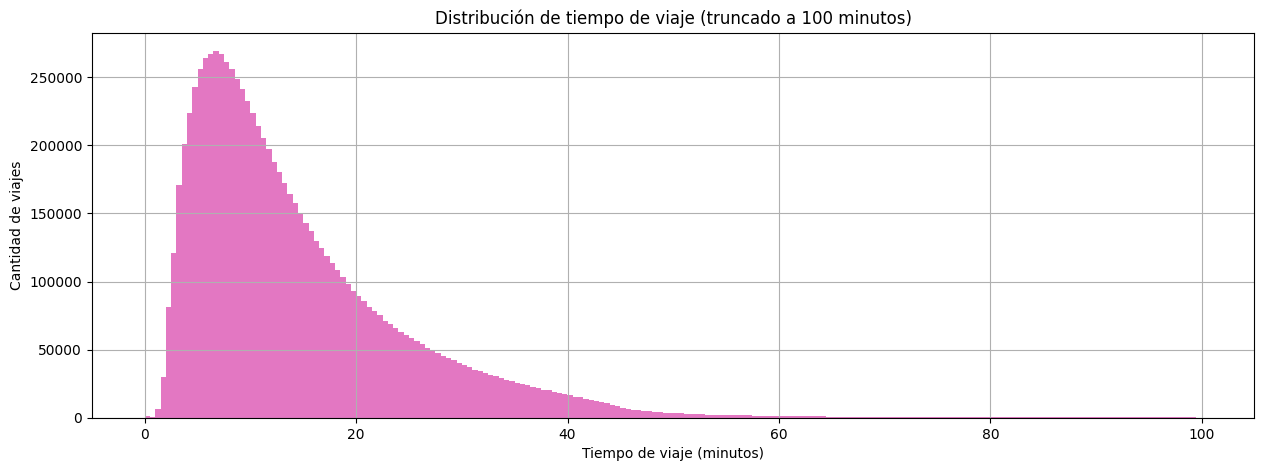

In [17]:
# Truncamos los valores mayores a 100 minutos para viualizar mejor la distribución
hora_df[hora_df.Diferencia_minutos<100].Diferencia_minutos.hist(bins=200,figsize=(15,5), color = 'C6')

# Editamos las gráficas
plt.title('Distribución de tiempo de viaje (truncado a 100 minutos)')
plt.xlabel('Tiempo de viaje (minutos)')
plt.ylabel('Cantidad de viajes')
plt.xticks(rotation=0)
plt.show()

In [18]:
# Finalmente hacemos una descripcion de la columna 'Diferencia_minutos'
hora_df.Diferencia_minutos.describe()

count    8.718360e+06
mean     1.576473e+01
std      2.882460e+01
min      0.000000e+00
25%      7.066667e+00
50%      1.168333e+01
75%      1.931667e+01
max      1.439583e+03
Name: Diferencia_minutos, dtype: float64